In [4]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import utils
import random

## Monte-Carlo Methods: Introduction

The foundation of the theory of derivative pricing is __the random walk of asset prices__. In this method, we will exploit the __relationship between asset prices and expectations__. 

First we will show the relationship between derivative values and expectations with deterministic interest rates

## Relationship between derivative values and simulations

The fair value of an option in the BSM world is the __present value of the expected payoof at expiry under a risk-neutral random walk__. 

The risk-neutral random-walk for S:

$$dS = rSdt + \sigma S dW$$

We can therefore write, for the value of an option at $t$:

$$V_t = e^{-r(T-t)}\mathbb{E}[\text{Payoff}(S)]$$

This result leads to an estimate for the value of an option by following three simple steps: 

- Simulate risk-neutral random walk, starting at today's value of the asset $S_0$, over the required time horizon. 
- For this realization compute the option payoff. 
- Perform many more such realizations. 
- Compute the average payoff over the all realizations. 
- Take the present value of the average. 

## Generating paths and computing derivative's value. 

The initial part of the algorithm requires first of all the generation of random numbrs from a standardized normal distribution or some suitable approximation). 

An obvious choice is to use: 

$$\delta S = rS\delta t + \sigma S \sqrt{t}\phi$$

Where $\phi$ is drawn from a standard normal distribution. Simply put the latest value of $S$ into the right-handed side to calculate $\delta S$ and hence the next value for S. The Euler method has a $\mathcal{O}(\delta t)$ error. Better to use the __Milstein Method (https://en.wikipedia.org/wiki/Milstein_method)__. 

## Greeks Estimation

The simplest way to compute the delta of an option using Monte-Carlo is to estimate the option's value twice. The delta of the option is the derivative of the option with respect to the underlying: 

$$\Delta = \lim_{{h \to 0}} \frac{V(S + h,t) - V(s - h, t)}{2h}$$

To overcome some measurement errors we will estimate the values of the option at $S + h$ and $S - h$ __using the same values for the random numbers.__ In this way the errors will cancel each other out. 

Use the same principal to compute gamma and theta of the option. 

If we are dealing with a lognormal random walk then things are much simpler than this. Somulate many lognormal random prices as usual, strating with stocks at $S$. All you need to do is to multiply the final stock value by $1+ \epsilon$ and by $1 - \epsilon$. Now use the new scaled prices to compute the payoff and thus, the new option value. Then difference these two new option values and divide by $2\epsilon S$ and you have your delta. 

<u>Our Case:</u> In our code, method *Compute_Vanilla_European_Option_Value* will compute an european derivative value and the delta for the option. It will use the method described below with $\epsilon = 0.01$.

In [35]:
def simulate_asset_path(S0, risk_free_rate, volatility, NTS, T, display = False, N=10000):
    """
    Simulating realizations of log-normal risk-neutral random walk

    :param S0: Initial asset price
    :param risk_free_rate: risk-free spot rate
    :param volatility: historical vol
    :param NTS: number of time steps
    :param T: Derivatives expiration
    :param N: Number of realizations
    :param display: Boolean - if we want to display some of the simulated paths

    :return:  2D array (NTS x N) having asset prices for every simulation (simulated path for each column).
    """
    realization_array = np.zeros((NTS, N))
    # We will start at S0 for every simulation
    realization_array[0, :] = [S0 for simulation in range(N)]
    dt = T / NTS
    for simulation in (range(N)):
        random_variable = np.random.normal(0, 1, NTS)
        for timestep in range(1, NTS):
            realization_array[timestep, simulation] = realization_array[timestep - 1, simulation] \
                                                      * math.exp((risk_free_rate - 1 / 2 * volatility ** 2) * dt
                                                                 + volatility * math.sqrt(dt) * random_variable[
                                                                     timestep])
    if display:
        num_columns = 10
        selected_columns = np.random.choice(N, size=num_columns, replace=False)
        plt.figure(figsize=(10, 6))
        for column in selected_columns:
            plt.plot(realization_array[:, column], linewidth=1.5)
            # Personalizar el gráfico
        plt.xlabel("Time Step")
        plt.ylabel("Asset Value")
        plt.title("10 Simulated Asset Paths")
        plt.show()
    return realization_array

Here we will compute the velue of an European Vanilla Option using the asset paths generated by last method. We will use deterministic spot rates. 

In [36]:
def Compute_Vanilla_European_Option_Value(S0, risk_free_rate, volatility, Expiry, Strike, Option_Type="C"):
    """
    Will compute the value of an European Vanilla Option using the asset paths on last method. With deterministic
    Interest rate.

    :param S0: Initial asset price
    :param risk_free_rate: spot risk-free rate
    :param volatility: historical vol
    :param Expiry: maturity of contract
    :param Strike: Strike of the option
    :param Option_Type: Call or put

    :return: PV of payoff's average.
    """
    S_paths = simulate_asset_path(S0, risk_free_rate, volatility, 1000, Expiry, display = False)
    last_price = S_paths[-1, :]
    if Option_Type == "C":
        q = 1
    else:
        q = -1
    Payoff = [math.exp(-risk_free_rate * Expiry) * max(q * (element - Strike), 0) for element in last_price]
    Delta_Payoff = [math.exp(-risk_free_rate * Expiry) * max(q * (element * (1 + 0.01) - Strike), 0) - math.exp(
        -risk_free_rate * Expiry) * max(q * (element * (1 - 0.01) - Strike), 0) for element in last_price]
    output = sum(Payoff) / len(Payoff)
    Delta = (sum(Delta_Payoff) / len(Delta_Payoff)) / 2 * 0.01 * S0
    return output, Delta

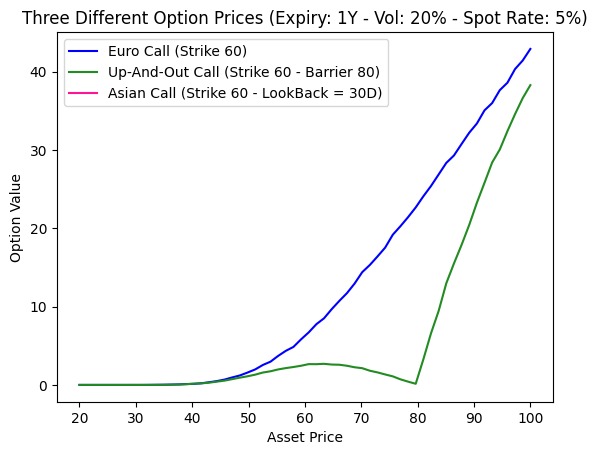

In [39]:
prices = np.linspace(20, 100, 60)
euro_option_values = [Compute_Vanilla_European_Option_Value(S0, 0.05, 0.2, 1, 60, Option_Type="C")[0] for S0 in prices]
barrier_option_values =[Compute_Barrier_Option_Value(S0, 0.05, 0.2, 1, 60, 80, Option_Type="C",Barrier_Type="O") for S0 in prices]
asian_option_values = [Compute_Asian_Option_Value(S0, 0.05, 0.2, Expiry = 1, LookBack_Period=30, Option_Type="C",DisplayMode=False) for S0 in prices]

# Trazar las tres curvas
plt.plot(prices, euro_option_values, color = "blue", label='Euro Call (Strike 60)')
plt.plot(prices, barrier_option_values, color="forestgreen", label='Up-And-Out Call (Strike 60 - Barrier 80)')
plt.plot(prices, asian_option_values , color="deeppink", label='Asian Call (Strike 60 - LookBack = 30D)')

# Configurar el título y las etiquetas de los ejes
plt.title('Three Different Option Prices (Expiry: 1Y - Vol: 20% - Spot Rate: 5%)')
plt.xlabel('Asset Price')
plt.ylabel('Option Value')

# Mostrar una leyenda con los nombres de las curvas
plt.legend()

# Mostrar el gráfico
plt.show()


In [25]:
def Compute_Barrier_Option_Value(S0, risk_free_rate, volatility, Expiry, Strike, Barrier, Option_Type="C",
                                 Barrier_Type="I"):
    """
    Will compute the value of an European Vanilla Option using the asset paths on last method. With deterministic
    Interest rate.

    :param S0: Initial asset price
    :param risk_free_rate: spot risk-free rate
    :param volatility: historical vol
    :param Expiry: maturity of contract
    :param Strike: Strike of the option
    :param Barrier: Barrier value
    :param Option_Type: Call or put
    :param Barrier_Type: "I" or "O" for knock-in or knock-out

    :return: PV of payoff's average.
    """
    # First analyze the difference between S0 and the barrier to see if it is an up or down option.
    if S0 < Barrier:
        Directional_Type = "UP"
    else:
        Directional_Type = "DOWN"

    S_paths = simulate_asset_path(S0, risk_free_rate, volatility, 1000, Expiry, display = False)
    last_price = S_paths[-1, :]
    if Option_Type == "C":
        q = 1
    else:
        q = -1
    # Option's payoff if this was a vanilla one.
    Payoff = [math.exp(-risk_free_rate * Expiry) * max(q * (element - Strike), 0) for element in last_price]
    
    #We will see now how many paths touched the barrier during option's life.
    if Barrier_Type == "I":
        if Directional_Type == "UP":
            for path in range(len(last_price)):
                Asset_path = S_paths[:, path]
                if np.count_nonzero(Asset_path >= Barrier) > 0:
                    d = 1
                else:
                    d = 0
                Payoff[path] = d * Payoff[path]
        else:
            for path in range(len(last_price)):
                Asset_path = S_paths[:, path]
                #Condition:  if it is an "IN" option, and the barrier is touched: same payoff than corresponding vanilla one. 
                if np.count_nonzero(Asset_path <= Barrier) > 0:
                    d = 1
                else:
                    d = 0
                Payoff[path] = d * Payoff[path]
    if Barrier_Type == "O":
        if Directional_Type == "UP":
            for path in range(len(last_price)):
                Asset_path = S_paths[:, path]
                #Condition:  if it is an "OUT" option, and the barrier is not touched: same payoff than corresponding vanilla one. 
                if np.count_nonzero(Asset_path >= Barrier) > 0:
                    d = 0
                else:
                    d = 1
                Payoff[path] = d * Payoff[path]
        else:
            for path in range(len(last_price)):
                Asset_path = S_paths[:, path]
                if np.count_nonzero(Asset_path <= Barrier) > 0:
                    d = 0
                else:
                    d = 1
                Payoff[path] = d * Payoff[path]

    output = sum(Payoff) / len(Payoff)
    return output

In [34]:
def Compute_Asian_Option_Value(S0, risk_free_rate, volatility, Expiry, LookBack_Period=30, Option_Type="C",
                               DisplayMode=False):
    """
    Will compute the value of an Asian Vanilla Option using the asset paths on last method. With deterministic
    Interest rate.

    :param S0: Initial asset price
    :param risk_free_rate: spot risk-free rate
    :param volatility: historical vol
    :param Expiry: maturity of contract
    :param LookBack_Period: Number of days on which the averaging will be based
    :param Option_Type: Call or put
    :param DisplayMode: A random asset path (risk free rate) will be shown in order to see if everything is correct

    :return: PV of payoff's average.
    """
    # Number of time divisions between today and option's maturity.
    NTS = 1000
    # convert the number of days entered as parameter to number of periods in the simulation.
    # You can choose one year to have 260 days (number of business days on a year). Or 365 if you want
    Number_Periods = int(LookBack_Period * (NTS / (Expiry * 365)))
    S_paths = simulate_asset_path(S0, risk_free_rate, volatility, NTS, Expiry, display = False)
    averages = [[S_paths[Number_Periods * i, path] for i in range(1, int(NTS / Number_Periods))] for path in
                range(len(S_paths[0]))]
    averages = list(map(utils.mean, averages))
    last_price = S_paths[-1, :]
    if Option_Type == "C":
        q = 1
    else:
        q = -1
    Payoff = [math.exp(-risk_free_rate * Expiry) * max(q * (last_price[i] - averages[i]), 0) for i in
              range(len(last_price))]
    output = sum(Payoff) / len(Payoff)
    if DisplayMode:
        Path_number = random.randint(0, len(S_paths[0]) - 1)
        path = S_paths[:, Path_number]
        average = averages[Path_number]
        plt.axhline(average, color="red", linestyle="--")
        plt.plot(path)
        plt.show()

## Interest Rate products

The correct way to estimate option value with stochastic interest rates is as follows:

- Simulate the random walk for the risk-adjusted spot interest rate, starting at today's value of the spot rate, over the required time horizon. 
- For this realization compute two quantities, the payoff and the average interest rate realized up to payoff. 
- Perform much more realizations. 
- For each realization of the $r$ random walk calculate the present value of the payoff for this realization discounting at the average rate for this realization.
- Calculate the average of the present values of the payoff over all realizations, __this is the option value.__

The choice of discretization of spot rate models is usually limited to the Euler Method. 

For the Vasicek model: 

$$\delta r_t = a(b - r_t)\delta t + \sigma \sqrt{\delta t} \phi$$

In [21]:
def simulate_spot_rate_path(r0, reversion_rate, mean_rate, volatility, NTS, T,display = True, N=10000):
    """
    Simulating realizations of log-normal risk-neutral random walk

    :param r0: Initial rate
    :param reversion_rate: mean reversion rate
    :param volatility: historical vol of the spot rate. 
    :param NTS: number of time steps
    :param T: Derivative expiration
    :param N: Number of realizations

    :return:  2D array (NTS x N) having asset prices for every simulation.
    """
    realization_array = np.zeros((NTS, N))
    # We will start at S0 for every simulation
    realization_array[0, :] = [r0 for simulation in range(N)]
    dt = T / NTS
    for simulation in tqdm(range(N)):
        random_variable = np.random.normal(0, 1, NTS)
        for timestep in range(1, NTS):
            realization_array[timestep, simulation] = realization_array[timestep - 1, simulation] + reversion_rate*(mean_rate - realization_array[timestep - 1, simulation])*dt + volatility*math.sqrt(dt) * random_variable[
                                                                     timestep]
    if display:
        num_columns = 10
        selected_columns = np.random.choice(N, size=num_columns, replace=False)
        plt.figure(figsize=(10, 6))
        for column in selected_columns:
            plt.plot(realization_array[:, column], linewidth=1.5)
            # Personalizar el gráfico
        plt.xlabel("Time Step")
        plt.ylabel("Spot Rate")
        plt.title("10 Simulated Rate Paths")
        plt.show()
    return realization_array

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2297.41it/s]


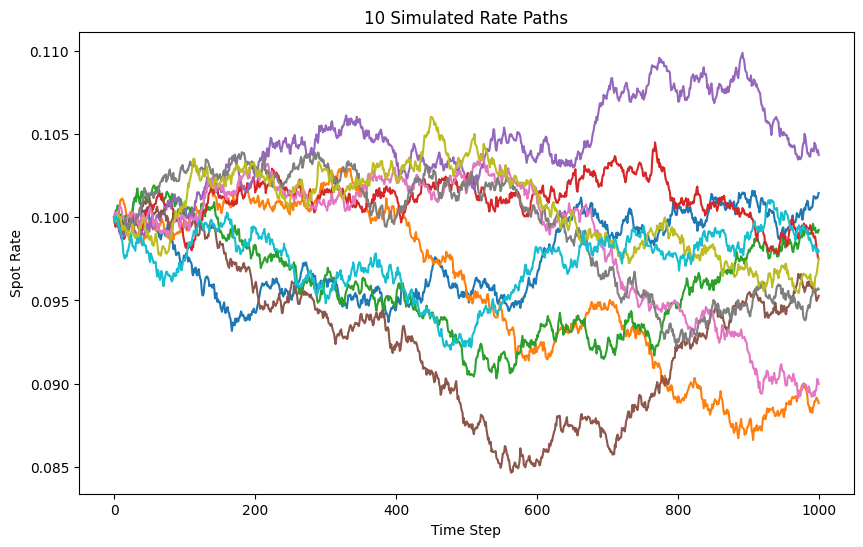

array([[0.1       , 0.1       , 0.1       , ..., 0.1       , 0.1       ,
        0.1       ],
       [0.10000522, 0.10006874, 0.0998782 , ..., 0.0999512 , 0.10011739,
        0.10015529],
       [0.0998355 , 0.09985285, 0.09993473, ..., 0.09991173, 0.0999383 ,
        0.10018009],
       ...,
       [0.09961336, 0.09681573, 0.09189997, ..., 0.0885708 , 0.08117013,
        0.09493674],
       [0.09945024, 0.09656768, 0.09203469, ..., 0.08865064, 0.08098718,
        0.09493996],
       [0.09917522, 0.09657884, 0.0923703 , ..., 0.08847495, 0.08096965,
        0.09497687]])

In [22]:
r0 = 0.1
mean_rate = 0.08
reversion_rate = 0.2
volatility = 0.007
timestep = 1000
T = 1
simulate_spot_rate_path(r0, reversion_rate, mean_rate, volatility, timestep, T)

## Advantages of Monte-Carlo simulation

We will give some benefits  of using such simulations:

- The mathematics behind it can be very basic.
- Correlations can be easily modeled.
- To get better accurracy just perform a higher number of simulations.
- Complex path dependency can be easily incorporated. 